<a href="https://colab.research.google.com/github/realfolkcode/convexity-graph-embeddings/blob/main/convexity_old_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TODO:** 

 ~- implement HOPE (test naive implementation and implement the JDGSVD one)~
 
 ~- study the complexity of *get_from_hull* function~

# Main functions

In [ ]:
from __future__ import print_function
from IPython.display import clear_output
import torch
from itertools import combinations
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import numpy as np
import networkx as nx
from time import time
from random import choice
from scipy.spatial.distance import euclidean
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import normalize
from scipy.spatial import Delaunay
from copy import copy
from sklearn.decomposition import PCA
from sklearn.manifold import MDS
import tensorflow as tf
from tensorflow import keras
import pandas as pd
#from queue import Queue

import warnings
warnings.filterwarnings("ignore")

In [ ]:
def get_hull_fw(G, FW, s):
    side = set(copy(s))
    new = {1}
    
    while len(new) != 0:
        new = set()
        for start, finish in list(combinations(side, 2)):
            for node in set(G.nodes()) - side:
                if FW[start, finish] > 1 and FW[start, node] + FW[node, finish] == FW[start, finish]:
                    new.add(node)
                    #print(node, start, finish)
        #print(new)
        side = side.union(new)
    return list(side)

In [ ]:
#G = nx.convert_node_labels_to_integers(nx.read_edgelist('/content/drive/MyDrive/facebook_combined.txt'))
#G.remove_nodes_from(list(G.nodes())[200:])
#FW = nx.floyd_warshall_numpy(G)
G = nx.karate_club_graph()
A = nx.adjacency_matrix(G).todense()

FW = nx.floyd_warshall_numpy(G)
GFW = nx.convert_matrix.from_numpy_matrix(FW)

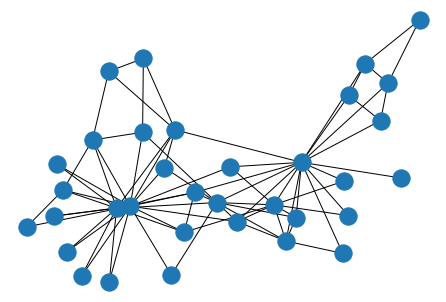

In [ ]:
nx.draw(G)

In [ ]:
def in_hull(p, hull):
    """
    Test if points in `p` are in `hull`

    `p` should be a `NxK` coordinates of `N` points in `K` dimensions
    `hull` is either a scipy.spatial.Delaunay object or the `MxK` array of the 
    coordinates of `M` points in `K`dimensions for which Delaunay triangulation
    will be computed
    """
    
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    return hull.find_simplex(p)>=0

In [ ]:
def get_from_hull(emb, hull):
    if not isinstance(hull,Delaunay):
        hull = Delaunay(hull)

    n = emb.shape[0]
    res = []
    for i in range(n):
        if hull.find_simplex(emb[i])>=0:
            res.append(i)
    return res

In [ ]:
def comparison_score(s1, s2):
    return len(set(s1).intersection(set(s2))) / len(set(s1).union(set(s2)))

In [ ]:
def projection_score(h_graph, h_space):
    # h_graph and h_space need to be sorted!

    s = len(h_space)
    err = 0
    s_itr = 0
    for g_itr in range(len(h_graph)):
        while s_itr < len(h_space) and h_space[s_itr] < h_graph[g_itr]:
            err += 1
            s_itr += 1
        s_itr += 1

    return (s - err) / s

In [ ]:
def test_comparison(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    mean_score = 0
    i = 0
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        try:
            h = Delaunay(emb[base].tolist())
            h_space = get_from_hull(emb, h)
            s = comparison_score(h_space, h_graph)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score

In [ ]:
def test_projection(emb, G, n_itr, n_base, log=True):
    np.random.seed(42)
    mean_score = 0
    i = 0
    while i < n_itr:
        base = np.random.choice(np.arange(nx.number_of_nodes(G)), n_base, replace=False)
        h_graph = get_hull_fw(G, FW, base)
        try:
            h = Delaunay(emb[h_graph])
            h_space = get_from_hull(emb, h)
            s = projection_score(h_graph, h_space)
            if log:
                print(s)
            mean_score += s
            i += 1
        except:
            if log:
                print('Delaunay error')
    mean_score /= n_itr
    return mean_score

In [ ]:
def distance_matrix(emb):
    n = emb.shape[0]
    D = np.empty((n,n))
    for i in range(n):
        for j in range(n):
            D[i, j] = np.linalg.norm(emb[i] - emb[j])
    return D

# Node2Vec

## Implementation

In [ ]:
!pip install node2vec

  Created wheel for node2vec: filename=node2vec-0.4.1-cp37-none-any.whl size=5734 sha256=b80bfd7e25679ce44d756cf37e5ddb4cd295aebb2b4c8caa888154e452a0b5b5
  Stored in directory: /root/.cache/pip/wheels/b3/59/ea/22e964f74bb864c5423cf82027a4d69dd65bac0bbf95fd46f5
Successfully built node2vec


In [ ]:
from node2vec import Node2Vec

In [ ]:
def n2v(G, K, walk_length=5, num_walks=750, p=1, q=20):
    n2v = Node2Vec(G, dimensions=3, walk_length=5, num_walks=750, p=p, q=q)
    model = n2v.fit()
    model.wv.save_word2vec_format('Karate.txt')
    with open('Karate.txt', 'r') as f:
        n, m = map(int, f.readline().split(' '))
        Kd = dict()
        for line in f.readlines():
            nums = list(map(float, line.split(' ')))
            Kd[int(nums[0])] = nums[1:]
        emb  = np.array(list(Kd.values()))
    return emb

## Testing Node2Vec

In [ ]:
scores_comparison = []
scores_projection = []

for _ in range(10):
    emb = n2v(G, 3, p=1, q=20)
    scores_comparison.append(test_comparison(emb, G, 50, 4, log=False))
    scores_projection.append(test_projection(emb, G, 50, 4, log=False))

scores_comparison = np.array(scores_comparison)
scores_projection = np.array(scores_projection)

print(scores_comparison)
print('Average comparison score:', np.mean(scores_comparison))
print('Difference:', np.max(np.abs(scores_comparison - np.mean(scores_comparison))))
print(' ')

print(scores_projection)
print('Average projection score:', np.mean(scores_projection))
print('Difference:', np.max(np.abs(scores_projection - np.mean(scores_projection))))

Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 139.16it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 162.69it/s]


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 155.97it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 167.45it/s]


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 151.76it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.18it/s]


Generating walks (CPU: 1):   2%|▏         | 18/750 [00:00<00:04, 176.51it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.01it/s]


Generating walks (CPU: 1):   1%|          | 7/750 [00:00<00:10, 68.28it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 155.84it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 133.64it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.11it/s]


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 115.87it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.14it/s]


Generating walks (CPU: 1):   1%|▏         | 10/750 [00:00<00:07, 94.20it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 159.97it/s]


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 156.78it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 164.62it/s]


Generating walks (CPU: 1):   2%|▏         | 18/750 [00:00<00:04, 171.23it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 166.21it/s]


[0.27442804 0.27400699 0.27395608 0.27442804 0.27442804 0.27368357
 0.27231693 0.27553915 0.2803777  0.27299529]
Average comparison score: 0.27461598388748737
Difference: 0.005761714601935253
 
[0.93839234 0.89012816 0.8927147  0.92532071 0.90495637 0.90708136
 0.90388724 0.942      0.89353584 0.88743252]
Average projection score: 0.9085449249276019
Difference: 0.03345507507239798


In [ ]:
p = 1
q = 20
n2v = Node2Vec(G, dimensions=3, walk_length=5, num_walks=750, p=p, q=q)
model = n2v.fit()
model.wv.save_word2vec_format('Karate.txt')

Generating walks (CPU: 1):   2%|▏         | 18/750 [00:00<00:04, 171.74it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 164.30it/s]


In [ ]:
with open('Karate.txt', 'r') as f:
    n, m = map(int, f.readline().split(' '))
    Kd = dict()
    for line in f.readlines():
        nums = list(map(float, line.split(' ')))
        Kd[int(nums[0])] = nums[1:]
    emb  = np.array(list(Kd.values()))

In [ ]:
emb

array([[ 4.1264316e-01, -5.1489190e-01, -1.8464110e+00],
       [ 1.7144977e+00,  6.5619280e-01, -4.4291016e-02],
       [ 5.6982870e-01, -8.2129997e-01, -2.3442645e+00],
       [ 2.4238067e+00, -3.8700277e-01, -3.2635390e-01],
       [ 1.3353354e+00, -6.1522030e-01, -6.3044864e-01],
       [ 4.5672797e-02,  8.5351010e-01, -1.1988982e+00],
       [ 2.8576834e+00, -4.7909993e-01, -2.7322778e-01],
       [ 2.0593321e+00,  2.8530746e+00, -5.6871086e-01],
       [ 2.0151834e+00,  2.8917100e+00, -6.1282015e-01],
       [-2.1739535e-01,  5.1790920e-01, -2.8384893e+00],
       [ 3.1206518e-02, -2.3836952e-01, -3.6948990e+00],
       [ 1.0628608e+00, -9.4616720e-01, -1.2091582e+00],
       [-5.4976042e-02,  2.4748125e+00, -2.8804777e+00],
       [ 1.6285907e+00, -5.0145113e-01, -4.0416348e-01],
       [-2.0526631e-01,  2.0894150e+00, -3.1068637e+00],
       [-3.2609552e-03,  8.1594280e-01, -1.4708258e+00],
       [ 1.2465588e+00, -1.2469174e+00, -1.4012061e+00],
       [ 2.6785636e+00,  2.2263

In [ ]:
print('Comparison score:', test_comparison(emb, G, 50, 4, log=False))

Comparison score: 0.2731473399844646


In [ ]:
print('Projection score:', test_projection(emb, G, 50, 4, log=False))

Projection score: 0.9419999999999998


## Dimesionality reduction

In [ ]:
p = 1
q = 20
dim_space = [8, 12, 16, 30]
for d in dim_space:
    tsne_projection = []
    tsne_comparison = []
    pca_projection = []
    pca_comparison = []
    for _in in range(10):
        n2v = Node2Vec(G, dimensions=d, walk_length=5, num_walks=750, p=p, q=q)
        model = n2v.fit()
        model.wv.save_word2vec_format('Karate.txt')
        with open('Karate.txt', 'r') as f:
            n, m = map(int, f.readline().split(' '))
            Kd = dict()
            for line in f.readlines():
                nums = list(map(float, line.split(' ')))
                Kd[int(nums[0])] = nums[1:]
            emb = np.array(list(Kd.values()))
        emb_tsne = TSNE(n_components=3).fit_transform(emb)
        emb_pca = PCA(n_components=3).fit_transform(emb)
        tsne_projection.append(test_projection(emb_tsne, G, 50, 4, log=False))
        tsne_comparison.append(test_comparison(emb_tsne, G, 50, 4, log=False))
        pca_projection.append(test_projection(emb_pca, G, 50, 4, log=False))
        pca_comparison.append(test_comparison(emb_pca, G, 50, 4, log=False))
    print('Dimension:', d)
    print('TSNE Average projection score:', np.mean(tsne_projection))
    print('TSNE Difference:', np.max(np.abs(tsne_projection - np.mean(tsne_projection))))
    print('TSNE Average comparison score:', np.mean(tsne_comparison))
    print('TSNE Difference:', np.max(np.abs(tsne_comparison - np.mean(tsne_comparison))))
    print('PCA Average projection score:', np.mean(pca_projection))
    print('PCA Difference:', np.max(np.abs(pca_projection - np.mean(pca_projection))))
    print('PCA Average comparison score:', np.mean(pca_comparison))
    print('PCA Difference:', np.max(np.abs(pca_comparison - np.mean(pca_comparison))))
    print(' ')

Generating walks (CPU: 1):   2%|▏         | 13/750 [00:00<00:05, 129.79it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 162.38it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 134.74it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 155.87it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 135.63it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 163.18it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:05, 145.02it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.30it/s]


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 117.11it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 156.54it/s]


Generating walks (CPU: 1):   2%|▏         | 17/750 [00:00<00:04, 167.82it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.12it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:04, 148.03it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 165.30it/s]


Generating walks (CPU: 1):   2%|▏         | 17/750 [00:00<00:04, 162.67it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 163.54it/s]


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:06, 107.93it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 158.38it/s]


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 157.09it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 163.97it/s]


Dimension: 8
TSNE Average projection score: 0.7435470161986217
TSNE Difference: 0.1171664592787156
TSNE Average comparison score: 0.2794123365648873
TSNE Difference: 0.011416207320595562
PCA Average projection score: 0.7930349485321835
PCA Difference: 0.07567477794592614
PCA Average comparison score: 0.2755386861130971
PCA Difference: 0.0055716567828156816
 


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 133.68it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.94it/s]


Generating walks (CPU: 1):   2%|▏         | 13/750 [00:00<00:05, 127.20it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.21it/s]


Generating walks (CPU: 1):   2%|▏         | 13/750 [00:00<00:05, 123.98it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 159.96it/s]


Generating walks (CPU: 1):   2%|▏         | 13/750 [00:00<00:05, 124.18it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.94it/s]


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:06, 107.43it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 160.44it/s]


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:07, 103.57it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 158.62it/s]


Generating walks (CPU: 1):   1%|▏         | 10/750 [00:00<00:07, 98.87it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:05<00:00, 148.25it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:05, 141.26it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 157.58it/s]


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 119.21it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 162.77it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 135.76it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 159.01it/s]


Dimension: 12
TSNE Average projection score: 0.7474168599163569
TSNE Difference: 0.1143740950732246
TSNE Average comparison score: 0.27754889085652973
TSNE Difference: 0.00950688603435279
PCA Average projection score: 0.8152255720148641
PCA Difference: 0.08545314850184249
PCA Average comparison score: 0.2718020333714235
PCA Difference: 0.008821186306850526
 


Generating walks (CPU: 1):   0%|          | 0/750 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 164.19it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:05, 146.43it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 159.89it/s]


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 113.69it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 150.71it/s]


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:06, 109.17it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 157.30it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 132.21it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 158.65it/s]


Generating walks (CPU: 1):   2%|▏         | 17/750 [00:00<00:04, 162.71it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 156.73it/s]


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 113.48it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:05<00:00, 149.99it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 133.10it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 164.18it/s]


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:07, 102.78it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.42it/s]


Generating walks (CPU: 1):   2%|▏         | 17/750 [00:00<00:04, 168.67it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 159.80it/s]


Dimension: 16
TSNE Average projection score: 0.7339313483878275
TSNE Difference: 0.13134667518190857
TSNE Average comparison score: 0.2777396228888892
TSNE Difference: 0.011030703784183471
PCA Average projection score: 0.8201166654703039
PCA Difference: 0.0970287207224505
PCA Average comparison score: 0.2729898965619115
PCA Difference: 0.004547253101365389
 


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:06, 108.92it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 162.93it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:05, 141.46it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 162.20it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:05, 141.30it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 159.85it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 133.14it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 157.15it/s]


Generating walks (CPU: 1):   1%|▏         | 10/750 [00:00<00:07, 97.92it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 160.09it/s]


Generating walks (CPU: 1):   2%|▏         | 15/750 [00:00<00:05, 140.88it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 165.29it/s]


Generating walks (CPU: 1):   1%|▏         | 11/750 [00:00<00:07, 104.10it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.99it/s]


Generating walks (CPU: 1):   0%|          | 0/750 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 157.32it/s]


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 118.10it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 163.25it/s]


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 132.98it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 164.07it/s]


Dimension: 30
TSNE Average projection score: 0.7454531247753386
TSNE Difference: 0.12625714291072176
TSNE Average comparison score: 0.2772805749240962
TSNE Difference: 0.007868858311787352
PCA Average projection score: 0.8538169027243624
PCA Difference: 0.05852718542750601
PCA Average comparison score: 0.27362546273068533
PCA Difference: 0.005594983525620156
 


# SGD Factorization

## Implementation

In [ ]:
def dotdec(u, v):
    return u.dot(v)

def distdec(u, v):
    return  torch.dist(u, v)
    
def cosdec(u, v):
    return torch.cosine_similarity(u, v, dim=0)

In [ ]:
def sim(i, j, A):
    return A[i, j]

In [ ]:
def loss(X, A, dec):
    s = 0
    for i, j in list(combinations(range(len(X)), 2)):
        l = (dec(X[i],X[j]) - A[i, j])**2
        #print(l)
        s += l
    return s

In [ ]:
def findX(X, A, dec, niter=500, lr=0.01, thres=0.01, log=True):
    optimizer = torch.optim.SGD([X], lr=lr)
    prev = np.inf
    for i in range(niter):
        optimizer.zero_grad()
        #ttime = time()
        loss(X, A, dec).backward()
        optimizer.step()
        #print(X.grad, X, '\n')
        #print(time() - ttime)
        if log:
            print(loss(X, A, dec))
        #print(time() - ttime)
        if prev - loss(X, A, dec) < thres:
            break
        prev = loss(X, A, dec)
    print(loss(X, A, dec))
    return X

## Testing Euclidean distance as decoder

In [ ]:
scores_comparison = []
scores_projection = []

for _ in range(10):
    X = torch.rand((34,3), requires_grad=True,)
    findX(X, FW, distdec, niter=500, lr=0.01, thres=0.1, log=False) #FW, niter=300, lr=0.006)
    TX = X.detach().numpy()
    scores_comparison.append(test_comparison(TX, G, 50, 4, log=False))
    scores_projection.append(test_projection(TX, G, 50, 4, log=False))

scores_comparison = np.array(scores_comparison)
scores_projection = np.array(scores_projection)

print(scores_comparison)
print('Average comparison score:', np.mean(scores_comparison))
print('Difference:', np.max(np.abs(scores_comparison - np.mean(scores_comparison))))
print(' ')

print(scores_projection)
print('Average projection score:', np.mean(scores_projection))
print('Difference:', np.max(np.abs(scores_projection - np.mean(scores_projection))))

KeyboardInterrupt: ignored

## Testing Dot product as decoder

In [ ]:
scores_comparison = []
scores_projection = []

for _ in range(10):
    X = torch.rand((34,3), requires_grad=True,)
    findX(X, FW, dotdec, niter=300, lr=0.006, thres=0.01, log=False) #FW, niter=300, lr=0.006)
    TX = X.detach().numpy()
    scores_comparison.append(test_comparison(TX, G, 50, 4, log=False))
    scores_projection.append(test_projection(TX, G, 50, 4, log=False))

scores_comparison = np.array(scores_comparison)
scores_projection = np.array(scores_projection)

print(scores_comparison)
print('Average comparison score:', np.mean(scores_comparison))
print('Difference:', np.max(np.abs(scores_comparison - np.mean(scores_comparison))))
print(' ')

print(scores_projection)
print('Average projection score:', np.mean(scores_projection))
print('Difference:', np.max(np.abs(scores_projection - np.mean(scores_projection))))

tensor(363.7135, grad_fn=<AddBackward0>)
tensor(342.8928, grad_fn=<AddBackward0>)
tensor(349.1624, grad_fn=<AddBackward0>)
tensor(338.8018, grad_fn=<AddBackward0>)
tensor(341.1222, grad_fn=<AddBackward0>)
tensor(364.5445, grad_fn=<AddBackward0>)
tensor(344.7632, grad_fn=<AddBackward0>)
tensor(343.5356, grad_fn=<AddBackward0>)
tensor(272.8129, grad_fn=<AddBackward0>)
tensor(363.2384, grad_fn=<AddBackward0>)
[0.27182147 0.27747856 0.27611625 0.28484328 0.27164741 0.28115549
 0.27675303 0.2766061  0.26141524 0.27477566]
Average comparison score: 0.2752612479084507
Difference: 0.013846012397886076
 
[0.84330465 0.82502848 0.86171913 0.87506794 0.84426989 0.87810826
 0.88950853 0.83152498 0.80539502 0.82204428]
Average projection score: 0.847597117312519
Difference: 0.04220209233463312


## Testing Cosine as decoder

In [ ]:
scores_comparison = []
scores_projection = []

for _ in range(10):
    X = torch.rand((34,3), requires_grad=True,)
    findX(X, A, dotdec, niter=300, lr=0.006, thres=0.01, log=False) #FW, niter=300, lr=0.006)
    TX = X.detach().numpy()
    scores_comparison.append(test_comparison(TX, G, 50, 4, log=False))
    scores_projection.append(test_projection(TX, G, 50, 4, log=False))

scores_comparison = np.array(scores_comparison)
scores_projection = np.array(scores_projection)

print(scores_comparison)
print('Average comparison score:', np.mean(scores_comparison))
print('Difference:', np.max(np.abs(scores_comparison - np.mean(scores_comparison))))
print(' ')

print(scores_projection)
print('Average projection score:', np.mean(scores_projection))
print('Difference:', np.max(np.abs(scores_projection - np.mean(scores_projection))))

tensor(29.8785, grad_fn=<AddBackward0>)
tensor(29.8961, grad_fn=<AddBackward0>)
tensor(29.9465, grad_fn=<AddBackward0>)
tensor(29.8253, grad_fn=<AddBackward0>)
tensor(29.9095, grad_fn=<AddBackward0>)
tensor(32.5349, grad_fn=<AddBackward0>)
tensor(29.9063, grad_fn=<AddBackward0>)
tensor(29.9814, grad_fn=<AddBackward0>)
tensor(32.8142, grad_fn=<AddBackward0>)
tensor(29.9610, grad_fn=<AddBackward0>)
[0.28128641 0.28990089 0.27962834 0.28851974 0.28828813 0.27527325
 0.29507166 0.27111425 0.26744765 0.27263841]
Average comparison score: 0.28091687319127073
Difference: 0.014154787398629132
 
[0.91683666 0.90210164 0.89191535 0.91442116 0.89369944 0.90446661
 0.91157845 0.93171298 0.89743146 0.92679926]
Average projection score: 0.9090963012589155
Difference: 0.022616675627745497


## Node2Vec initialization

In [ ]:
scores_comparison = []
scores_projection = []

for _ in range(10):
    emb = n2v(G, 3, p=1, q=20)
    X = torch.tensor(emb, requires_grad=True)
    findX(X, FW, distdec, niter=500, lr=0.01, thres=0.1, log=False) #FW, niter=300, lr=0.006)
    TX = X.detach().numpy()
    scores_comparison.append(test_comparison(TX, G, 50, 4, log=False))
    scores_projection.append(test_projection(TX, G, 50, 4, log=False))

scores_comparison = np.array(scores_comparison)
scores_projection = np.array(scores_projection)

print(scores_comparison)
print('Average comparison score:', np.mean(scores_comparison))
print('Difference:', np.max(np.abs(scores_comparison - np.mean(scores_comparison))))
print(' ')

print(scores_projection)
print('Average projection score:', np.mean(scores_projection))
print('Difference:', np.max(np.abs(scores_projection - np.mean(scores_projection))))

Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 158.74it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 163.89it/s]


tensor(89.0909, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 13/750 [00:00<00:05, 124.36it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 160.45it/s]


tensor(87.7102, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 137.29it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 163.42it/s]


tensor(89.5460, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 14/750 [00:00<00:05, 133.40it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.43it/s]


tensor(100.0974, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 18/750 [00:00<00:04, 173.84it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.58it/s]


tensor(92.8702, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 150.20it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 157.84it/s]


tensor(97.5252, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 12/750 [00:00<00:06, 116.88it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 160.94it/s]


tensor(85.9828, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 156.44it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 166.72it/s]


tensor(94.2759, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 17/750 [00:00<00:04, 161.24it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 155.95it/s]


tensor(93.7332, dtype=torch.float64, grad_fn=<AddBackward0>)


Generating walks (CPU: 1):   2%|▏         | 16/750 [00:00<00:04, 156.70it/s]

Generating walks (CPU: 1): 100%|██████████| 750/750 [00:04<00:00, 161.35it/s]


tensor(95.7853, dtype=torch.float64, grad_fn=<AddBackward0>)
[0.29527142 0.29626295 0.29159583 0.28240348 0.29997181 0.30401639
 0.29111808 0.2994764  0.29740288 0.29868337]
Average comparison score: 0.2956202613407889
Difference: 0.013216783647097219
 
[0.94133333 0.93610902 0.93866667 0.9249125  0.93118839 0.92010297
 0.94133333 0.93855901 0.92540456 0.93460663]
Average projection score: 0.9332216410591695
Difference: 0.013118666230794607


# HOPE

## Implementation

In [ ]:
def get_prob_transition(G):
    return normalize(nx.to_numpy_array(G), axis=1, norm='l1')

In [ ]:
def pagerank_matrix(G, alpha):
    P = get_prob_transition(G)
    n = P.shape[0]
    return (1 - alpha) * np.linalg.inv(np.identity(n) - alpha * P)

In [ ]:
def katz_matrix(G, alpha):
    A = nx.to_numpy_array(G)
    n = A.shape[0]
    A = alpha * A
    return np.linalg.inv(np.identity(n) -A) @ A

In [ ]:
def cn_matrix(G):
    A = nx.to_numpy_array(G)
    return A @ A

In [ ]:
def hope(G, K, alpha, prox='pagerank'):
    # K is the dimension of embeddings

    if prox == 'pagerank':
        S = pagerank_matrix(G, alpha)
    elif prox == 'katz':
        S = katz_matrix(G, alpha)
    elif prox == 'cn':
        S = cn_matrix(G)
    elif prox == 'fw':
        S = nx.floyd_warshall_numpy(G)

    n = S.shape[0]
    u, s, vh = np.linalg.svd(S)
    source = u[:, :K].copy()
    target = vh[:K, :].copy()
    for i in range(K):
        source[:, i] *= np.sqrt(s[i])
        target[i, :] *= np.sqrt(s[i])
    
    return source, target.T

## Testing HOPE on RPR proximity

In [ ]:
# Comparison score
np.random.seed(42)

for i in range(5):
    print(' ')
    base = np.random.choice(np.arange(len(G)), 5, replace=False)
    h_graph = get_hull_fw(G, FW, base)
    for alpha in np.linspace(0.1, 0.9, 9):
        S = pagerank_matrix(G, alpha)
        emb = hope(G, 3, alpha)[0]
        h = Delaunay(emb[base].tolist())
        h_space = get_from_hull(emb, h)
        print(alpha, np.linalg.cond(S), comparison_score(h_space, h_graph))

 
32 8 15
33 8 15
0 8 19
33 8 19
33 8 26
2 8 27
33 8 27
33 15 19
33 15 26
33 15 27
33 19 26
33 19 27
33 26 27
31 32 0
29 32 26
23 32 27
9 33 2
13 33 2
28 33 2
13 33 0
31 33 0
1 2 19
9 2 26
13 2 26
28 2 26
29 2 26
13 0 26
31 0 26
13 0 15
31 0 15
30 32 1
30 33 1
25 0 23
30 1 8
30 1 15
30 1 23
30 1 26
30 1 29
25 23 31
24 27 31
0.1 1.263062941283435 0.21739130434782608
0.2 1.6086461195693098 0.21739130434782608
0.30000000000000004 2.0729576125763023 0.21739130434782608
0.4 2.716058752016769 0.21739130434782608
0.5 3.645758578059526 0.21739130434782608
0.6 5.077455886089751 0.21739130434782608
0.7000000000000001 7.513901576687601 0.21739130434782608
0.8 12.465062611024516 0.21739130434782608
0.9 27.492582505752754 0.21739130434782608
 
2 0 23
8 0 23
13 0 23
19 0 23
25 0 23
27 0 23
31 0 23
32 0 23
33 0 23
2 5 23
8 5 23
13 5 23
19 5 23
25 5 23
27 5 23
31 5 23
32 5 23
33 5 23
2 7 23
27 7 23
32 7 23
2 10 23
8 10 23
13 10 23
19 10 23
25 10 23
27 10 23
31 10 23
32 10 23
33 10 23
9 33 2
28 33 2
1 

In [ ]:
# Projection score
np.random.seed(42)

for i in range(5):
    print(' ')
    base = np.random.choice(np.arange(len(G)), 5, replace=False)
    h_graph = get_hull_fw(G, FW, base)
    for alpha in np.linspace(0.1, 0.9, 9):
        S = pagerank_matrix(G, alpha)
        emb = hope(G, 3, alpha)[0]
        h = Delaunay(emb[h_graph])
        h_space = get_from_hull(emb, h)
        print(alpha, np.linalg.cond(S), projection_score(h_graph, h_space))

 
32 8 15
33 8 15
0 8 19
33 8 19
33 8 26
2 8 27
33 8 27
33 15 19
33 15 26
33 15 27
33 19 26
33 19 27
33 26 27
31 32 0
29 32 26
23 32 27
9 33 2
13 33 2
28 33 2
13 33 0
31 33 0
1 2 19
9 2 26
13 2 26
28 2 26
29 2 26
13 0 26
31 0 26
13 0 15
31 0 15
30 32 1
30 33 1
25 0 23
30 1 8
30 1 15
30 1 23
30 1 26
30 1 29
25 23 31
24 27 31
0.1 1.263062941283435 0.8260869565217391
0.2 1.6086461195693098 0.8260869565217391
0.30000000000000004 2.0729576125763023 0.8260869565217391
0.4 2.716058752016769 0.8260869565217391
0.5 3.645758578059526 0.8260869565217391
0.6 5.077455886089751 0.8260869565217391
0.7000000000000001 7.513901576687601 0.8260869565217391
0.8 12.465062611024516 0.8260869565217391
0.9 27.492582505752754 0.8260869565217391
 
2 0 23
8 0 23
13 0 23
19 0 23
25 0 23
27 0 23
31 0 23
32 0 23
33 0 23
2 5 23
8 5 23
13 5 23
19 5 23
25 5 23
27 5 23
31 5 23
32 5 23
33 5 23
2 7 23
27 7 23
32 7 23
2 10 23
8 10 23
13 10 23
19 10 23
25 10 23
27 10 23
31 10 23
32 10 23
33 10 23
9 33 2
28 33 2
1 33 7
3 33

## Testing HOPE on Katz proximity

In [ ]:
emb = hope(G, 3, 0.0215, 'katz')[0]

In [ ]:
# Comparison score

test_comparison(emb, G, 5, 5)

0.15315315315315314
0.10869565217391304
0.15625
0.2631578947368421
0.12195121951219512


0.16064158391522068

In [ ]:
# Projection score

test_projection(emb, G, 5, 5)

0.610738255033557
0.14285714285714285
0.12727272727272726
0.2916666666666667
0.060240963855421686


0.24655515113710313

In [ ]:
prox = katz_matrix(G, 0.05)
prox

array([[-1.04291853e+00, -5.67964269e-02, -2.96078038e-03, ...,
        -4.24677720e-02, -2.27172143e-03, -4.58599127e-01],
       [-5.67964269e-02,  2.06768815e-02, -3.89145869e-03, ...,
        -8.71835272e-03, -2.99641240e-03, -5.04603244e-02],
       [-2.96078038e-03, -3.89145869e-03,  1.21072470e-02, ...,
        -2.90999246e-03, -1.56714080e-04, -3.14079571e-02],
       ...,
       [-4.24677720e-02, -8.71835272e-03, -2.90999246e-03, ...,
         2.00658007e-02, -2.24240835e-03, -4.75263930e-02],
       [-2.27172143e-03, -2.99641240e-03, -1.56714080e-04, ...,
        -2.24240835e-03,  2.39236756e-03, -2.42107866e-02],
       [-4.58599127e-01, -5.04603244e-02, -3.14079571e-02, ...,
        -4.75263930e-02, -2.42107866e-02, -1.21152880e-01]])

## Testing HOPE on Common Neighbors

In [ ]:
emb = hope(G, 3, 0, prox='cn')[0]

In [ ]:
print('Projection score:', test_projection(emb, G, 100, 5))

32 8 15
33 8 15
0 8 19
33 8 19
33 8 26
2 8 27
33 8 27
33 15 19
33 15 26
33 15 27
33 19 26
33 19 27
33 26 27
31 32 0
29 32 26
23 32 27
9 33 2
13 33 2
28 33 2
13 33 0
31 33 0
1 2 19
9 2 26
13 2 26
28 2 26
29 2 26
13 0 26
31 0 26
13 0 15
31 0 15
30 32 1
30 33 1
25 0 23
30 1 8
30 1 15
30 1 23
30 1 26
30 1 29
25 23 31
24 27 31
0.8260869565217391
2 0 23
8 0 23
13 0 23
19 0 23
25 0 23
27 0 23
31 0 23
32 0 23
33 0 23
2 5 23
8 5 23
13 5 23
19 5 23
25 5 23
27 5 23
31 5 23
32 5 23
33 5 23
2 7 23
27 7 23
32 7 23
2 10 23
8 10 23
13 10 23
19 10 23
25 10 23
27 10 23
31 10 23
32 10 23
33 10 23
9 33 2
28 33 2
1 33 7
3 33 7
9 33 7
28 33 7
30 33 7
1 2 19
24 2 25
28 2 25
28 2 31
1 7 13
3 7 13
1 7 19
1 13 19
24 25 27
24 27 31
0.8695652173913043
8 0 22
13 0 22
19 0 22
31 0 22
32 0 22
33 0 22
8 0 26
13 0 26
19 0 26
31 0 26
33 0 26
3 2 12
32 2 22
8 2 26
9 2 26
13 2 26
27 2 26
28 2 26
29 2 26
32 2 26
33 2 26
3 12 22
8 12 22
13 12 22
19 12 22
31 12 22
32 12 22
33 12 22
3 12 26
8 12 26
13 12 26
19 12 26
31 12 26

In [ ]:
print('Comparison score:', test_comparison(emb, G, 100, 5))

32 8 15
33 8 15
0 8 19
33 8 19
33 8 26
2 8 27
33 8 27
33 15 19
33 15 26
33 15 27
33 19 26
33 19 27
33 26 27
31 32 0
29 32 26
23 32 27
9 33 2
13 33 2
28 33 2
13 33 0
31 33 0
1 2 19
9 2 26
13 2 26
28 2 26
29 2 26
13 0 26
31 0 26
13 0 15
31 0 15
30 32 1
30 33 1
25 0 23
30 1 8
30 1 15
30 1 23
30 1 26
30 1 29
25 23 31
24 27 31
0.21739130434782608
2 0 23
8 0 23
13 0 23
19 0 23
25 0 23
27 0 23
31 0 23
32 0 23
33 0 23
2 5 23
8 5 23
13 5 23
19 5 23
25 5 23
27 5 23
31 5 23
32 5 23
33 5 23
2 7 23
27 7 23
32 7 23
2 10 23
8 10 23
13 10 23
19 10 23
25 10 23
27 10 23
31 10 23
32 10 23
33 10 23
9 33 2
28 33 2
1 33 7
3 33 7
9 33 7
28 33 7
30 33 7
1 2 19
24 2 25
28 2 25
28 2 31
1 7 13
3 7 13
1 7 19
1 13 19
24 25 27
24 27 31
0.2727272727272727
8 0 22
13 0 22
19 0 22
31 0 22
32 0 22
33 0 22
8 0 26
13 0 26
19 0 26
31 0 26
33 0 26
3 2 12
32 2 22
8 2 26
9 2 26
13 2 26
27 2 26
28 2 26
29 2 26
32 2 26
33 2 26
3 12 22
8 12 22
13 12 22
19 12 22
31 12 22
32 12 22
33 12 22
3 12 26
8 12 26
13 12 26
19 12 26
31 12 2

## Analyzing the approximation error

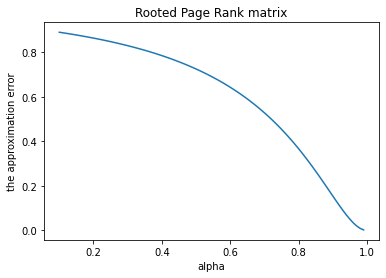

In [ ]:
error = []
for alpha in np.linspace(0.1, 1, 90, endpoint=False):
    prox = pagerank_matrix(G, alpha)
    u, s, vh = np.linalg.svd(prox)
    s = s**2
    error.append(np.sum(s[3:]) / np.sum(s))
plt.plot(np.linspace(0.1, 1, 90, endpoint=False), error)
plt.title('Rooted Page Rank matrix')
plt.xlabel('alpha')
plt.ylabel('the approximation error')
plt.show()

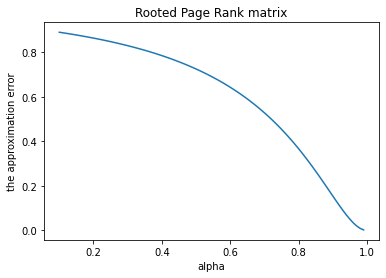

In [ ]:
error = []
for alpha in np.linspace(0.1, 1, 90, endpoint=False):
    prox = pagerank_matrix(G, alpha)
    source, target = hope(G, 3, alpha)
    u, s, vh = np.linalg.svd(prox)
    s = s**2
    error.append(np.linalg.norm(prox - source @ target.T, ord='fro')**2 / np.linalg.norm(prox, ord='fro')**2)
plt.plot(np.linspace(0.1, 1, 90, endpoint=False), error)
plt.title('Rooted Page Rank matrix')
plt.xlabel('alpha')
plt.ylabel('the approximation error')
plt.show()

In [ ]:
prox = pagerank_matrix(G, 0.97)
u, s, vh = np.linalg.svd(prox)
s = s**2
np.sum(s[3:]) / np.sum(s)

0.019573721595317

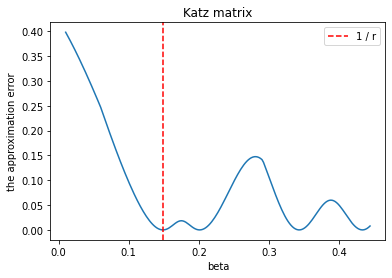

In [ ]:
# Computing the spectral radius
r = abs(np.linalg.eigvals(nx.to_numpy_array(G))[0])

error = []
for beta in np.linspace(0.01, 3 / r, 201, endpoint=False):
    prox = katz_matrix(G, beta)
    u, s, vh = np.linalg.svd(prox)
    s = s**2
    error.append(np.sum(s[3:]) / np.sum(s))
plt.plot(np.linspace(0.01, 3 / r, 201, endpoint=False), error)
plt.axvline(x=1/r, color='red', linestyle='--', label='1 / r')
plt.title('Katz matrix')
plt.xlabel('beta')
plt.ylabel('the approximation error')
plt.legend()
plt.show()

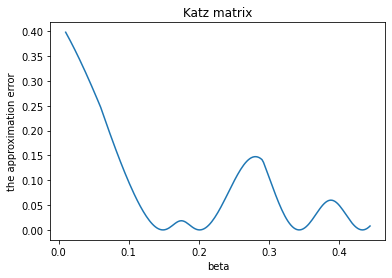

In [ ]:
# Computing the spectral radius
r = abs(np.linalg.eigvals(nx.to_numpy_array(G))[0])

error = []
for beta in np.linspace(0.01, 3 / r, 201, endpoint=False):
    prox = katz_matrix(G, beta)
    source, target = hope(G, 3, beta, 'katz')
    u, s, vh = np.linalg.svd(prox)
    s = s**2
    error.append(np.linalg.norm(prox - source @ target.T, ord='fro')**2 / np.linalg.norm(prox)**2)
plt.plot(np.linspace(0.01, 3 / r, 201, endpoint=False), error)
plt.title('Katz matrix')
plt.xlabel('beta')
plt.ylabel('the approximation error')
plt.show()

In [ ]:
# Computing the spectral radius
r = abs(np.linalg.eigvals(nx.to_numpy_array(G))[0])

prox = katz_matrix(G, 1 / r)
u, s, vh = np.linalg.svd(prox)
s = s**2
np.sum(s[3:]) / np.sum(s)

2.7754598332993997e-31

In [ ]:
prox = cn_matrix(G)
u, s, vh = np.linalg.svd(prox)
s = s**2
print(np.sum(s[3:]) / np.sum(s))

0.12421452657482658


In [ ]:
# RPR Comparison score (source)

emb = hope(G, 3, 0.97)[0]
print('Comparison score:', test_comparison(emb, G, 50, 4, log=False))

Comparison score: 0.2608878993219281


In [ ]:
# RPR Projection score (source)

emb = hope(G, 3, 0.97)[0]
print('Projection score:', test_projection(emb, G, 50, 4, log=False))

Projection score: 0.8265686834904225


In [ ]:
# RPR Comparison score (target)

emb = hope(G, 3, 0.97)[1]
print('Comparison score:', test_comparison(emb, G, 50, 4, log=False))

Comparison score: 0.25338875214015877


In [ ]:
# RPR Projection score (target)

emb = hope(G, 3, 0.97)[1]
print('Projection score:', test_projection(emb, G, 50, 4, log=False))

Projection score: 0.8337833958312215


In [ ]:
# Katz Comparison score

r = abs(np.linalg.eigvals(nx.to_numpy_array(G))[0])
emb = hope(G, 3, 1 / r, prox='katz')[0]
print('Comparison score:', test_comparison(emb, G, 50, 4, log=False))

Comparison score: 0.2586878552446192


In [ ]:
# Katz Projection score

r = abs(np.linalg.eigvals(nx.to_numpy_array(G))[0])
emb = hope(G, 3, 1 / r, prox='katz')[0]
print('Projection score:', test_projection(emb, G, 50, 4, log=False))

Projection score: 0.861879041731216


In [ ]:
# CN Comparison score

emb = hope(G, 3, 0, prox='cn')[0]
print('Comparison score:', test_comparison(emb, G, 50, 4, log=False))

Comparison score: 0.2540804464362009


In [ ]:
# CN Projection score

emb = hope(G, 3, 0, prox='cn')[0]
print('Projection score:', test_projection(emb, G, 50, 4, log=False))

Projection score: 0.8137542520281648


## High dimensional embeddings

In [ ]:
nx.graph_clique_number(G)

5

In [ ]:
# Projection score

emb = hope(G, 4, 0.97)[0]
print('Projection score:', test_projection(emb, G, 50, 6))

0.8260869565217391
0.875
0.84
0.7692307692307693
0.9090909090909091
0.8
0.875
0.9166666666666666
0.9565217391304348
0.8888888888888888
0.8076923076923077
0.8695652173913043
0.9444444444444444
0.95
0.8636363636363636
0.9523809523809523
1.0
0.9090909090909091
0.9473684210526315
0.8
0.8571428571428571
1.0
0.8636363636363636
0.95
1.0
0.95
0.8
1.0
0.92
0.9444444444444444
0.8571428571428571
0.8
0.9166666666666666
0.9090909090909091
0.8571428571428571
0.9090909090909091
0.8333333333333334
0.9166666666666666
0.8
0.7857142857142857
0.8620689655172413
0.92
0.782608695652174
0.9047619047619048
0.8333333333333334
1.0
0.782608695652174
0.7586206896551724
1.0
0.8636363636363636
Projection score: 0.8855675068699768


In [ ]:
# Comparison score

emb = hope(G, 4, 0.97)[0]
print('Comparison score:', test_comparison(emb, G, 50, 6))

0.2608695652173913
0.25
0.24
0.28
0.3333333333333333
0.25
0.09523809523809523
0.25
0.2608695652173913
0.25
0.23076923076923078
0.2916666666666667
0.35294117647058826
0.3
0.2608695652173913
Delaunay error
0.3333333333333333
0.2727272727272727
0.3333333333333333
0.24
0.2608695652173913
Delaunay error
0.2608695652173913
0.3
0.2608695652173913
0.3
0.25
0.2727272727272727
0.2962962962962963
0.3333333333333333
0.2608695652173913
0.23076923076923078
0.2692307692307692
0.2727272727272727
0.2857142857142857
0.30434782608695654
0.25
0.25
0.24
0.23076923076923078
0.1724137931034483
0.23076923076923078
0.25
0.21739130434782608
0.24
0.38095238095238093
0.25
0.21428571428571427
Delaunay error
0.25
0.3157894736842105
0.25
0.2608695652173913
Comparison score: 0.26495632756816884


## Dimensionality reduction

In [ ]:
emb = hope(G, 20, 0.97)[0]
pca = PCA(n_components=3)
emb = pca.fit_transform(emb)
emb.shape

(34, 3)

In [ ]:
test_comparison(emb, G, 5, 5)

0.2857142857142857
0.22727272727272727
0.2
0.19230769230769232
0.2916666666666667


0.23939227439227442

In [ ]:
test_projection(emb, G, 5, 5)

0.8504672897196262
0.11428571428571428
0.047619047619047616
0.4
0.09090909090909091


In [ ]:
emb = hope(G, 20, 0.3, prox='katz')[0]
pca = PCA(n_components=3)
emb = pca.fit_transform(emb)
emb.shape

(200, 3)

In [ ]:
test_comparison(emb, G, 5, 5)

0.1111111111111111
0.2
0.21428571428571427
0.19230769230769232
0.29411764705882354


In [ ]:
test_projection(emb, G, 5, 5)

0.52
0.18181818181818182
0.15555555555555556
0.43333333333333335
0.11764705882352941


In [ ]:
emb = hope(G, 20, 0, prox='cn')[0]
pca = PCA(n_components=3)
emb = pca.fit_transform(emb)
emb.shape

(200, 3)

In [ ]:
test_comparison(emb, G, 5, 5)

0.12612612612612611
0.14705882352941177
0.1724137931034483
0.22727272727272727
0.125


In [ ]:
test_projection(emb, G, 5, 5)

0.6319444444444444
0.14492753623188406
0.1320754716981132
0.2916666666666667
0.06329113924050633


## Testing HOPE on FW

In [ ]:
emb = hope(G, 4, 0, 'fw')[0]

In [ ]:
# Comparison score

print(test_comparison(emb, G, 50, 6, log=False))

0.26514418844348614
